<a href="https://colab.research.google.com/github/NAJOO0/2022F-Ajou-ML/blob/main/baseline_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge :: Coin Classification

여러 나라의 동전 이미지를 보고 어느 나라의 동전인지 분류하는 테스크입니다.  
동전의 클래스는 인도, 유럽, 중국, 미국, 일본, 필리핀으로 총 6개 입니다.

각 나라의 label은 아래와 같이 설정합니다.
{'china_coins': 0,
 'euro_coins': 1,
 'indian_coins': 2,
 'peso_coins': 3,
 'us_coins': 4,
 'yen_coins': 5}

## Drive에서 데이터 가져오기 OR 로컬에서 파일 업로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive
#'알맞은 디렉토리 채우기'

/content/drive/MyDrive


In [ ]:
ls

'딥러닝 스터디'/                      IT_0926/
'집교1 정리본.zip'                    IT_0928/
 집중교육2/                           IT집중교육1-FLASK/
 201820807_Myeongkyu_Kong.pdf        'IT집중교육2_1조 (1).pdf'
 201820807_Myeongkyu_Kong.pptx       'IT 전문영어 대본-2.docx'
 201820807.zip                       'IT Professional English.pptx'
'2022_ML Challenge'/                 'lunar hovering bus.pptx'
'ai 대본.docx'                        monitoring_dataset_distributed.npy
 coins_images@                       'Pegasus (3) (1) (1).pptx'
'Colab Notebooks'/                    prediction_result.csv
'Embryo Classification Challenge'/   'Proposal PPT.pdf'
 English1_team6_v3.pptx               VGG16_bn_dropout.pt
'기계학습 프로젝트.gdoc'             'VGG16_bn_loss(0.5).pt'
 전공교과목실험실습비지급신청서.hwp   VGG16_bn.pt
 IT_0921/


## Load Data

In [ ]:
#util
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
#model
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
#dataset
from torchvision import transforms, utils, datasets,models
from torch.utils.data import Dataset, DataLoader
import torch.utils.data


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # prevent truncate error

In [ ]:
import PIL
img = PIL.Image.open('./coins_images/TEST/test_2.jpg') 
tf1 = transforms.Resize((256,256))
tf2 = transforms.RandomHorizontalFlip()
tf = transforms.ToTensor()
imgt = tf1(img)
imgt1=tf(imgt)
imgt2=tf(img)
# imgt=tf2(imgt)
# imgt=tf(imgt)
print(imgt1.size())
print(imgt1)

torch.Size([3, 256, 256])
tensor([[[0.5686, 0.5765, 0.5765,  ..., 0.5804, 0.5765, 0.5765],
         [0.5686, 0.5686, 0.5725,  ..., 0.5765, 0.5765, 0.5765],
         [0.5647, 0.5647, 0.5725,  ..., 0.5725, 0.5725, 0.5765],
         ...,
         [0.4667, 0.4627, 0.4667,  ..., 0.4824, 0.4745, 0.4667],
         [0.4510, 0.4510, 0.4510,  ..., 0.4784, 0.4706, 0.4667],
         [0.4392, 0.4392, 0.4314,  ..., 0.4745, 0.4706, 0.4667]],

        [[0.5725, 0.5804, 0.5804,  ..., 0.5725, 0.5765, 0.5765],
         [0.5686, 0.5725, 0.5765,  ..., 0.5725, 0.5765, 0.5765],
         [0.5686, 0.5686, 0.5765,  ..., 0.5725, 0.5725, 0.5765],
         ...,
         [0.4549, 0.4510, 0.4549,  ..., 0.4588, 0.4588, 0.4549],
         [0.4392, 0.4392, 0.4431,  ..., 0.4588, 0.4549, 0.4549],
         [0.4235, 0.4314, 0.4275,  ..., 0.4588, 0.4588, 0.4549]],

        [[0.5529, 0.5608, 0.5608,  ..., 0.5490, 0.5451, 0.5451],
         [0.5490, 0.5529, 0.5569,  ..., 0.5451, 0.5451, 0.5451],
         [0.5490, 0.5490, 0.5569

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

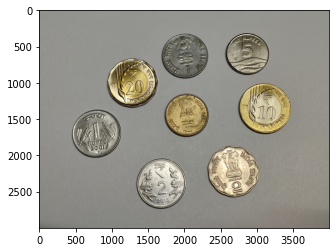

In [ ]:
imshow(imgt2)

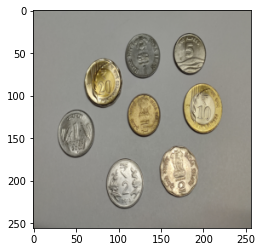

In [ ]:
imshow(imgt1)

In [ ]:
image_transforms = {
    "train": transforms.Compose([
            transforms.RandomOrder([
                  transforms.RandomHorizontalFlip(),
                  transforms.RandomVerticalFlip(),
                  transforms.RandomRotation(90),
              ]),
            # transforms.RandomInvert(),
                transforms.ToTensor(),
            transforms.Resize((224, 224)),
           transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
        
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}

In [ ]:
# From https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
train_data = ImageFolderWithPaths(root = './coins_images/' + "TRAIN", # load train data
                                   transform = image_transforms['train'],
                                  )
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True) # make train loader

In [ ]:
train_data

Dataset ImageFolderWithPaths
    Number of datapoints: 1229
    Root location: ./coins_images/TRAIN
    StandardTransform
Transform: Compose(
               RandomOrder(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
           )
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [ ]:
classes = train_data.class_to_idx # class name
classes

{'china_coins': 0,
 'euro_coins': 1,
 'indian_coins': 2,
 'peso_coins': 3,
 'us_coins': 4,
 'yen_coins': 5}

## Show Example Data

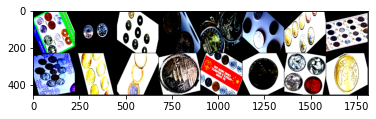

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
# print(dataiter.next())
images, labels, paths = dataiter.next()

batch_size = 16

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print()
labels = labels.tolist()
print(' '.join(f'{list(classes.keys())[list(classes.values()).index(j)]}' for j in labels))

## Define a Convolutional Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        ############### Conv2d, MaxPool2d, Linear 함수에 들어갈 파라미터를 채우세요 ##############
        self.conv1 = nn.Conv2d(3,3,3) # in_channel, out_channel, kernel size
        self.pool = nn.MaxPool2d(4,4) # kernel_size, stride
        self.conv2 = nn.Conv2d(4,8,3)
        self.fc1 = nn.Linear(10368,121) # in_features, out_features
        self.fc2 = nn.Linear(121,12)
        self.fc3 = nn.Linear(12,6)
        ###########################################################################################

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class VGG16(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3,64,3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64,64,3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64,128,3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128,128,3,padding=1),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2),
        nn.Conv2d(128,256,3,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256,256,3,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256,256,3,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.MaxPool2d(2,2),
        nn.Conv2d(256,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.MaxPool2d(2,2),
        nn.Conv2d(512,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.MaxPool2d(2,2),
    )
    self.classifi = nn.Sequential(
        nn.Linear(512*7*7,4096),
        nn.ReLU(True),
        nn.Dropout(0.25),
        nn.Linear(4096,1000),
        nn.ReLU(True),
        nn.Dropout(0.25),
        nn.Linear(1000,6)
    )
    self.conv1_1 = nn.Conv2d(3,64,3,padding=1)
    self.conv1_2 = nn.Conv2d(64,64,3,padding=1)

    self.conv2_1 = nn.Conv2d(64,128,3,padding=1)
    self.conv2_2 = nn.Conv2d(128,128,3,padding=1)

    self.conv3_1 = nn.Conv2d(128,256,3,padding=1)
    self.conv3_2 = nn.Conv2d(256,256,3,padding=1)
    self.conv3_3 = nn.Conv2d(256,256,3,padding=1)

    self.conv4_1 = nn.Conv2d(256,512,3,padding=1)
    self.conv4_2 = nn.Conv2d(512,512,3,padding=1)
    self.conv4_3 = nn.Conv2d(512,512,3,padding=1)

    self.conv5_1 = nn.Conv2d(512,512,3,padding=1)
    self.conv5_2 = nn.Conv2d(512,512,3,padding=1)
    self.conv5_3 = nn.Conv2d(512,512,3,padding=1)

    self.pool = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(7*7*512,4096)
    self.fc2 = nn.Linear(4096,1000)
    self.fc3 = nn.Linear(1000,6)
  def forward(self,x):
    x = self.conv(x)
    x = torch.flatten(x, 1)
    x = self.classifi(x)
    return x
    



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if it's available # colab 런타임 유형 변경에서 GPU 선택할 것
net = VGG16().to(device)
# print(net)
summary(net,(3,224,224),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
        MaxPool2d-13          [-1, 128, 56, 56]               0
           Conv2d-14          [-1, 256,

In [ ]:
net.parameters()

<generator object Module.parameters at 0x7f232363dba0>

##Load Network weight




In [ ]:
PATH='/content/drive/MyDrive/VGG16_bn_aug_loss(2).pt'
net = VGG16()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if it's available # colab 런타임 유형 변경에서 GPU 선택할 것
net = net.to(device) # send the network to the device
net.load_state_dict(torch.load(PATH))


RuntimeError: ignored

## Define a Loss function and optimizer

In [46]:
criterion = nn.CrossEntropyLoss() # loss function, 변경 가능
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # optimizer, 변경 가능
optimizer = optim.AdamW(net.parameters(),lr=0.000001)
# scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)
# scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,"min")

## Train the Network

In [47]:
net.train()
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, paths = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
        # print statistics
        running_loss += loss.item()
        if i % 15 == 14:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            running_loss = 0.0

print('Finished Training') # epoch이 50일 때, training acc 46% 달성

  0%|          | 0/77 [00:00<?, ?it/s]

[1,    15] loss: 2.536
[1,    30] loss: 3.706
[1,    45] loss: 3.794
[1,    60] loss: 2.521
[1,    75] loss: 3.268


  0%|          | 0/77 [00:00<?, ?it/s]

[2,    15] loss: 3.499
[2,    30] loss: 4.567
[2,    45] loss: 3.215
[2,    60] loss: 4.004
[2,    75] loss: 2.884


  0%|          | 0/77 [00:00<?, ?it/s]

[3,    15] loss: 3.128
[3,    30] loss: 3.522
[3,    45] loss: 3.221
[3,    60] loss: 2.564
[3,    75] loss: 3.352


  0%|          | 0/77 [00:00<?, ?it/s]

[4,    15] loss: 3.477
[4,    30] loss: 3.417
[4,    45] loss: 2.847
[4,    60] loss: 2.813
[4,    75] loss: 3.640


  0%|          | 0/77 [00:00<?, ?it/s]

[5,    15] loss: 4.297
[5,    30] loss: 4.501
[5,    45] loss: 2.573
[5,    60] loss: 2.510
[5,    75] loss: 3.048
Finished Training


## Calculate Training accuracy

In [48]:
train_test_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False) # make train_test loader

In [49]:
correct = 0
total = 0

t=0
f=0
image_id = []
predicted_label = []
net.eval()
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for i, data in enumerate(tqdm(train_test_loader,0)):
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        values,indexs = torch.topk(outputs.data, 1)
        if labels in indexs:
          t+=1
        else:
          f+=1
        image_id.append(paths)
        predicted_label.append(predicted.item())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print('path:', paths, 'predicted_label:', predicted)
print(f'Accuracy of the network on the {len(train_test_loader.dataset)} test images: {100 * correct // total} %')
print(f't:{t} f:{f}' )

  0%|          | 0/1229 [00:00<?, ?it/s]

Accuracy of the network on the 1229 test images: 97 %
t:1196 f:33


## Save the Network

In [ ]:
# # save the trained model
# PATH = './net_pretrained.pth'
# torch.save(net.state_dict(), PATH)

In [ ]:
PATH='/content/drive/MyDrive/VGG16_bn_aug_loss(2).pt'
torch.save(net.state_dict(), PATH)


## Testing & Making a Submission File

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import os

class testDataset(Dataset):
    def __init__(self, data_dir, transform):
        # path to images
        path2data = os.path.join(data_dir)

        # get a list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # set transformations
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        image_name = self.full_filenames[idx]
        return image, image_name

In [ ]:
test_data = testDataset('coins_images/TEST/',image_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False) # ALWAYS SET SHUFFLE FALSE

In [ ]:
total=0
correct=0
image_id = []
predicted_label = []
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for i, data in enumerate(tqdm(test_loader,0)):
        images, paths = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        path = os.path.basename(paths[0])
        image_id.append(path)
        predicted_label.append(predicted.item())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print('path:', paths, 'predicted_label:', predicted)
print(f'Accuracy of the network on the {len(test_loader.dataset)} test images: {100 * correct // total} %')

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 120 test images: 21 %


In [ ]:
predicted_df = pd.DataFrame({'image_id': image_id, 'predicted_label': predicted_label})

In [ ]:
predicted_df['predicted_label'] = predicted_df.predicted_label.astype(str)

In [ ]:
predicted_df.to_csv('prediction_result.csv', index=False)

##Efficient Net


In [ ]:
# #@title
# #Swish activation function
# class Swish(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.sigmoid = nn.Sigmoid()
#   def forward(self, x):
#         return x * self.sigmoid(x)
# #check
# if __name__ == '__main__':
#   x = torch.randn(3,3,224,224)
#   model = Swish()
#   output = model(x)
#   print('output size:',output.size())

In [ ]:
# #@title
# # SE Block
# class SEBlock(nn.Module):
#     def __init__(self, in_channels, r=4):
#         super().__init__()

#         self.squeeze = nn.AdaptiveAvgPool2d((1,1))
#         self.excitation = nn.Sequential(
#             nn.Linear(in_channels, in_channels * r),
#             Swish(),
#             nn.Linear(in_channels * r, in_channels),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.squeeze(x)
#         x = x.view(x.size(0), -1)
#         x = self.excitation(x)
#         x = x.view(x.size(0), x.size(1), 1, 1)
#         return x

# # check
# if __name__ == '__main__':
#     x = torch.randn(3, 56, 17, 17)
#     model = SEBlock(x.size(1))
#     output = model(x)
#     print('output size:', output.size())

In [ ]:
# #@title
# class MBConv(nn.Module):
#     expand = 6
#     def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
#         super().__init__()
#         # first MBConv is not using stochastic depth
#         self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

#         self.residual = nn.Sequential(
#             nn.Conv2d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
#             nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
#             Swish(),
#             nn.Conv2d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
#                       stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
#             nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
#             Swish()
#         )

#         self.se = SEBlock(in_channels * MBConv.expand, se_scale)

#         self.project = nn.Sequential(
#             nn.Conv2d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
#         )

#         self.shortcut = (stride == 1) and (in_channels == out_channels)

#     def forward(self, x):
#         # stochastic depth
#         if self.training:
#             if not torch.bernoulli(self.p):
#                 return x

#         x_shortcut = x
#         x_residual = self.residual(x)
#         x_se = self.se(x_residual)

#         x = x_se * x_residual
#         x = self.project(x)

#         if self.shortcut:
#             x= x_shortcut + x

#         return x

# # check
# if __name__ == '__main__':
#     x = torch.randn(3, 16, 24, 24)
#     model = MBConv(x.size(1), x.size(1), 3, stride=1, p=1)
#     model.train()
#     output = model(x)
#     x = (output == x)
#     print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])

In [ ]:
# #@title
# class SepConv(nn.Module):
#     expand = 1
#     def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
#         super().__init__()
#         # first SepConv is not using stochastic depth
#         self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

#         self.residual = nn.Sequential(
#             nn.Conv2d(in_channels * SepConv.expand, in_channels * SepConv.expand, kernel_size=kernel_size,
#                       stride=1, padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
#             nn.BatchNorm2d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
#             Swish()
#         )

#         self.se = SEBlock(in_channels * SepConv.expand, se_scale)

#         self.project = nn.Sequential(
#             nn.Conv2d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
#         )

#         self.shortcut = (stride == 1) and (in_channels == out_channels)

#     def forward(self, x):
#         # stochastic depth
#         if self.training:
#             if not torch.bernoulli(self.p):
#                 return x

#         x_shortcut = x
#         x_residual = self.residual(x)
#         x_se = self.se(x_residual)

#         x = x_se * x_residual
#         x = self.project(x)

#         if self.shortcut:
#             x= x_shortcut + x

#         return x

# # check
# if __name__ == '__main__':
#     x = torch.randn(3, 16, 24, 24)
#     model = SepConv(x.size(1), x.size(1), 3, stride=1, p=1)
#     model.train()
#     output = model(x)
#     # stochastic depth check
#     x = (output == x)
#     print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])

In [ ]:
# #@title
# class EfficientNet(nn.Module):
#     def __init__(self, num_classes=10, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
#         super().__init__()
#         channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
#         repeats = [1, 2, 2, 3, 3, 4, 1]
#         strides = [1, 2, 2, 2, 1, 2, 1]
#         kernel_size = [3, 3, 5, 3, 5, 5, 3]
#         depth = depth_coef
#         width = width_coef

#         channels = [int(x*width) for x in channels]
#         repeats = [int(x*depth) for x in repeats]

#         # stochastic depth
#         if stochastic_depth:
#             self.p = p
#             self.step = (1 - 0.5) / (sum(repeats) - 1)
#         else:
#             self.p = 1
#             self.step = 0


#         # efficient net
#         self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)

#         self.stage1 = nn.Sequential(
#             nn.Conv2d(3, channels[0],3, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(channels[0], momentum=0.99, eps=1e-3)
#         )

#         self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)

#         self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)

#         self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)

#         self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)

#         self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)

#         self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)

#         self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)

#         self.stage9 = nn.Sequential(
#             nn.Conv2d(channels[7], channels[8], 1, stride=1, bias=False),
#             nn.BatchNorm2d(channels[8], momentum=0.99, eps=1e-3),
#             Swish()
#         ) 

#         self.avgpool = nn.AdaptiveAvgPool2d((1,1))
#         self.dropout = nn.Dropout(p=dropout)
#         self.linear = nn.Linear(channels[8], num_classes)

#     def forward(self, x):
#         x = self.upsample(x)
#         x = self.stage1(x)
#         x = self.stage2(x)
#         x = self.stage3(x)
#         x = self.stage4(x)
#         x = self.stage5(x)
#         x = self.stage6(x)
#         x = self.stage7(x)
#         x = self.stage8(x)
#         x = self.stage9(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.dropout(x)
#         x = self.linear(x)
#         return x


#     def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
#         strides = [stride] + [1] * (repeats - 1)
#         layers = []
#         for stride in strides:
#             layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
#             in_channels = out_channels
#             self.p -= self.step

#         return nn.Sequential(*layers)


In [ ]:
# #@title
# def efficientnet_b0(num_classes=6):
#     return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)